In [23]:
using QuantumOptics
using Statistics
using PyPlot
using JLD2
using CollectiveSpins

# MPC computations, variable horizontal lattice

### Functions

In [24]:
function avgSz(rho)
    Sz = [CollectiveSpins.mpc.sz(ρ) for ρ in rho]
    meanSz = [mean(subarray) for subarray in Sz]
    return -1 .*(meanSz.+1) ./2 .- 6;
end

function calcEvolutionMPC(λ, d_xy, d_z, Tstep, Tend)
    a,b,c = [d_xy,d_xy,d_z]/λ
    geometry = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
    e = [0,0,1]   # Quantization axis
    system = CollectiveSpins.SpinCollection(geometry, e, gammas=1.)

    # Initial quantum state: fully inverted = theta=0
    phi = 0.
    theta = 0.#pi/2
    Ψ0 = CollectiveSpins.mpc.blochstate(phi, theta, N)
    T = [0:Tstep:Tend;]
    tout, ρt = CollectiveSpins.mpc.timeevolution(T, system, Ψ0, dt=Tstep)
    meanSz = avgSz(ρt)
    return meanSz
end

function calcSE_MPC(Tstep, Tend)
    a,b,c = [266.,266.,532.]
    geometry = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
    e = [0,0,1]   # Quantization axis
    system = CollectiveSpins.SpinCollection(geometry, e, gammas=1.)
    
    Ψ0 = CollectiveSpins.independent.blochstate(0., 0., N)
    T = [0:Tstep:Tend;]
    tout, ρt_ind = CollectiveSpins.independent.timeevolution(T, system, Ψ0, dt=Tstep)
    Sz = [CollectiveSpins.independent.sz(ρ) for ρ in ρt_ind]
    meanSz_ind = [mean(subarray) for subarray in Sz]
    return -1 .*(meanSz_ind.+1) ./2 .- 6;
end

calcSE_MPC (generic function with 1 method)

### Define the system

In [25]:
# Define geometry of system
Nx,Ny,Nz = [5,5,3] #5x5x3=75 sites takes about 6 seconds to calculate on my laptop (first time is slower ofcourse)
N = Nx*Ny*Nz

# Define computation variables
Tstep, Tend = 0.05, 0.05
Lambda_array = [583, 631, 841, 1299]
num_points_per_lambda = 100

d_array = [range(0, 2*λ, length=num_points_per_lambda) for λ in Lambda_array]
d_array = hcat(d_array...)';

### Computations

In [26]:
# Compute Spontaneous emission diff at t=0
diff_meanSz_SE_t0 = diff(calcSE_MPC(Tstep, Tend))[1]/Tstep;

In [32]:
# Prepare matrix for all lambda and all d
norm_diff_meanSz_t0 = zeros(size(Lambda_array)[1], num_points_per_lambda)

for i in 1:size(Lambda_array)[1]
    println(string(i)*"/"*string(size(Lambda_array)[1]))
    for j in 1:size(d_array[i,:])[1]
        norm_diff_meanSz_t0[i,j] = (diff(calcEvolutionMPC(Lambda_array[i], d_array[i,j], 532., Tstep, Tend))[1]/Tstep)/diff_meanSz_SE_t0
    end
end

1/4
2/4
3/4
4/4


# Plots

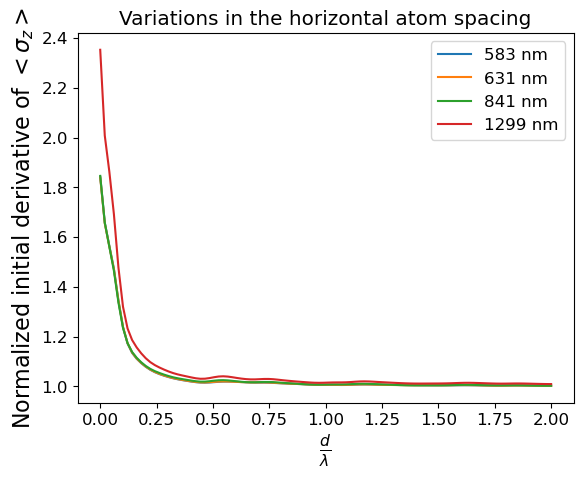

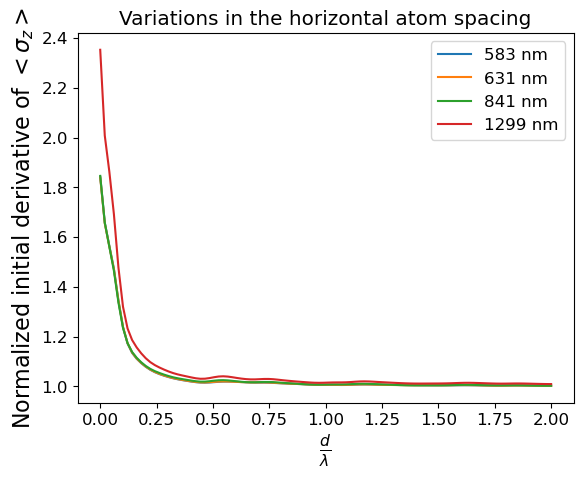

In [33]:
close("all")
figure()

PyPlot.rc("font", size = 12)

# Plot
for i in 1:size(Lambda_array)[1]
    plot(d_array[i,:]/Lambda_array[i], norm_diff_meanSz_t0[i,:], label=string(Lambda_array[i])*" nm")
end

title("Variations in the horizontal atom spacing")
xlabel(L"\frac{d}{\lambda}", fontsize=16)
ylabel(L"\text{Normalized initial derivative of } <\sigma_z>", fontsize=16)
legend()

pygui(false); gcf()

### Zoom plots

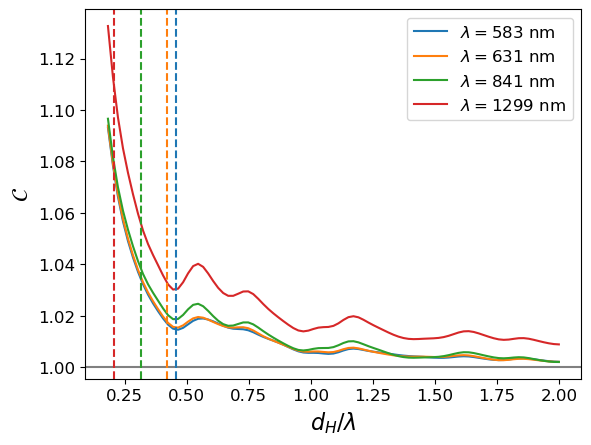

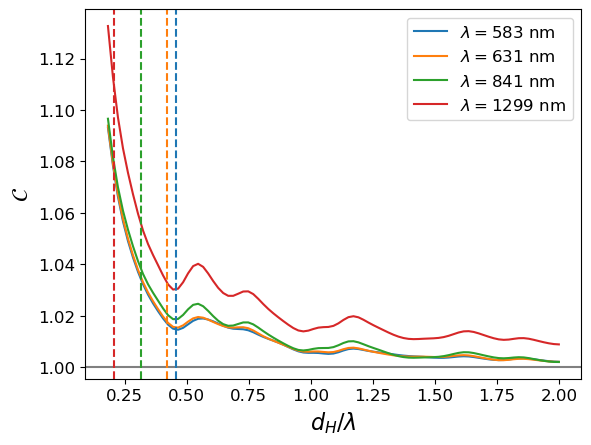

In [37]:
close("all")
figure()

colorz = String[]
idx_start = 10
for i in 1:size(Lambda_array)[1]
    plt = plot(d_array[i,idx_start:end]/Lambda_array[i], norm_diff_meanSz_t0[i,idx_start:end], label=L"\lambda="*string(Lambda_array[i])*" nm")
    push!(colorz,plt[1].get_color())
end

axhline(1, color="grey")
xlabel(L"d_H/\lambda", fontsize=16)
ylabel(L"\mathcal{C}", fontsize=16) #\partial_t<\sigma_z>(t=0)\gamma

# Add setup d/λ
for i in 1:size(Lambda_array)[1]
    axvline(266/Lambda_array[i], linestyle="--", color = colorz[i])
end

#title("Variations in the horizontal atom spacing")
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Criterium_SR_Initial_Slope.pdf", bbox_inches="tight")


pygui(false); gcf()

In [30]:
# Save data
save_object("Initial_Slope_Hor(d_over_lambda).jld2", norm_diff_meanSz_t0);

In [31]:
# Load data
norm_diff_meanSz_t0 = load_object("Initial_Slope_Hor(d_over_lambda).jld2");

In [38]:
40*pi/180


0.6981317007977318